# Data Structure:
- Galaxies (group)
  - Attributes(group)
    - halo_ids (dataset)
    - mass (dataset)
    - ...
  - Particles (group)
    - DM (group)
      - ...
    - Stars (group)
      - Maps (group)
        - Mass (dataset)
        - Metal (dataset)
        - Age (dataset)
      - ...
    - Gas (group)
      - ...


In [2]:
import h5py
import os 
from galaxy import Galaxy
from tqdm import tqdm

In [1]:
def _create_data_structure(n_galaxies, image_res,galaxy_parameters, particle_types, fields, path="./"):
    '''Creates the HDF5 data structure for the galaxy data
    #TODO: Add the ability to save the images as a 3D array
    #TODO: Add the ability to set different fields for different particle types
    Parameters
    ----------
    n_galaxies: int
        Number of galaxies to be saved
    image_res: tuple
        Image resolution (x,y) #TODO: Change to be flexible (x,y,z) for 3D images
    galaxy_parameters: list
        List of galaxy parameters to be saved
    particle_types: list
        List of particle types to be saved.
    fields: dict
        Dictionary of fields to be saved, where  key is the field name and the value is a boolean indicating if the field is mass weighted or not. 
        The fields are the same for all particle types and are saved in the "Images" group. The value is used to calculate the image later. #TODO maybe change this
    path: str
        Path to the HDF5 file
    
    
    Example:
    --------
    create_data_structure(1000, (64,64), galaxy_paramters=["mass","halo_id"], particle_types =["stars"], {"Masses":False, "GFM_Metallicity":False, "GFM_StellarFormationTime":True})
    
    This will create a "galaxy_data.hdf5" HDF5 file with the following structure and save it to the current directory:
    ---------------------------------------------------------
    Galaxies
        Attributes
            mass
            halo_id
        Particles
            stars
                Images
                    Masses
                    GFM_Metallicity
                    GFM_StellarFormationTime
    ---------------------------------------------------------

    '''
    # Open the HDF5 file in "w" mode to create a new file
    with h5py.File(os.path.join(path, "galaxy_data.hdf5"), "w") as f:
        # Create the Galaxies group
        galaxies_group = f.create_group("Galaxies")
        galaxy_attributes = galaxies_group.create_group("Attributes")
        # Create the datasets for the galaxy parameters
        for parameter in galaxy_parameters:
            galaxy_attributes.create_dataset(parameter, shape=(n_galaxies,), maxshape=(None,))    
        
        particles_group = galaxies_group.create_group("Particles")
        # Create the Particle Types group
        for particle_type in particle_types:
            particle_type_group = particles_group.create_group(particle_type)
            
            # Create the Images group
            images_group = particle_type_group.create_group("Images")
            
            # Create the datasets for the images
            for field in fields:
                images_group.create_dataset(field, shape=(n_galaxies, *image_res), maxshape=(None, None,None))
                



def _calculate_images(simulation,halo_ids,fields,plot_factor, image_res, path="./",**kwargs):
    '''Calculates the images for the galaxies and saves them to the HDF5 file. Needs to be run after _create_data_structure() method.
    
    Parameters
    ----------
    simulation: str
        Simulation name (e.g. IllustrisTNG). Used to initialise the Galaxy class. The Galaxy class for a specific simulation should be defined in the simulations.py file. #TODO: Change name
    halo_ids: list
        List of halo IDs to calculate the images for. The halo_ids are used to load the galaxy data from the simulation.
    fields: dict
        Dictionary of fields to be saved. The key is the field name and the value is a boolean indicating if the calculated field image should mass weighted or not.
            e.g {"Masses":False, "GFM_Metallicity":False, "GFM_StellarFormationTime":True}
    plot_factor: float
        Factor for the image range. The image range is calculated as halfmass_radius*plot_factor and the image is centred on the galaxy centre.
        For the halfmass_radius only the particle type specified in the particle_type argument are used.
    path: str
        Path to the HDF5 file to save the data to. This file should be created using create_data_structure() method.
    **kwargs: dict
        Keyword arguments passed to the Galaxy class. Halo ID and particle type are overwritten in the loop.
        e.g. {"base_path":basePath,"halo_id":0,"particle_type": "stars", "snapshot":99} for IllustrisTNG

    '''
    # Check if the HDF5 file exists, which should be created using create_data_structure() method.
    if not os.path.exists(os.path.join(path, "galaxy_data.hdf5")):
        raise FileNotFoundError(f"{os.path.join(path, 'galaxy_data.hdf5')} does not exist. This should have been created using the _create_data_structure() method.")
    
    n_galaxies = len(halo_ids)
    # Open the HDF5 file in "append" mode
    with h5py.File(os.path.join(path,"galaxy_data.hdf5"), "a") as f:
        
        # Check if the "index_position" attribute exists
        if "index_position" in f.attrs:
            index_position = f.attrs["index_position"]
            
            # Ask the user if they want to continue from the last index position
            if input(f"Continue from index position {index_position}? (y/n): ") == "y":
                # Check if the index position is valid
                if index_position > n_galaxies:
                    raise ValueError(f"Index position {index_position} is greater than the number of galaxies {n_galaxies}")        
            else:
                # Reset the index position since the user does not want to continue from the last index position 
                index_position = 0
        else:
            #Attribute does not exist so set the index position to 0 to start the loop from the beginning
            index_position = 0

        
        
        # Loop through the galaxies
        for index, haloid in tqdm(enumerate(halo_ids[index_position:])):
            # Create the galaxy object
            kwargs["halo_id"] = haloid
            
            g = Galaxy(simulation= simulation, **kwargs) 
            
            # Get the galaxy parameters
            for parameter in f["Galaxies/Attributes"].keys():
                if hasattr(g,parameter):
                    f["Galaxies/Attributes"][parameter][index] = getattr(g,parameter)
                else: 
                    raise ValueError(f"Galaxy class does not have the attribute {parameter}")
                
            # Get the particle data
            for particle_type in f["Galaxies"]["Particles"].keys():
                # Get the particle data
                for field in f["Galaxies"]["Particles"][particle_type]["Images"].keys():
                    # Get the image
                    image = g.get_image(field, plot_factor, image_res, mass_weighted=fields[field])
                    f["Galaxies"]["Particles"][particle_type]["Images"][field][index] = image
            
            # Update the index position
            f.attrs["index_position"] += 1
            
        # Show the user that the images have been calculated
        print("Images calculated and saved to HDF5 file: ", os.path.join(path,"galaxy_data.hdf5"))
        

In [1]:

# Set the parameters
simulation = "IllustrisTNG" # Simulation name
particle_types = ["stars"] # Particle types
image_res = (64,64) # Image resolution
halo_ids= [15,20]


path = "./"

fields = {"Masses":False, 
          "GFM_Metallicity":False,
          "GFM_StellarFormationTime":True} # Fields to calculated images for and if they are mass weighted or not
plot_factor = 10 # Plot factor for the image: plot_factor*halfmassrad = image range

galaxy_parameters = ["mass","halo_id"] # Attributes of Galaxy Class to be saved for each galaxy (TODO: This atm only works for scalar parameters)
basePath = f"/export/data/ucakir/TNG100/TNG100-1/output/"

# Arguments passed to the galaxy class. Halo ID and particle type are overwritten in the loop.
kwargs = {"base_path":basePath,"halo_id":0,"particle_type": "stars", "snapshot":99}


# Open the HDF5 file in "w" mode to create a new file

# Check if galaxy_data.hdf5 exists
if os.path.exists(os.path.join(path, "galaxy_data.hdf5")):
    # Ask the user if they want to overwrite the file
    if input(f"{os.path.join(path, 'galaxy_data.hdf5')} already exists. Do you want to overwrite it? (y/n)") == "y":
        # Overwrite the file
        create_data_structure(galaxy_parameters, particle_types, fields, path)
    
    
    
    
    



    

0it [00:00, ?it/s]

No unit conversion for Field GFM_Metallicity. Return without changes.


1it [00:13, 13.90s/it]

No unit conversion for Field GFM_Metallicity. Return without changes.


2it [00:21, 10.68s/it]


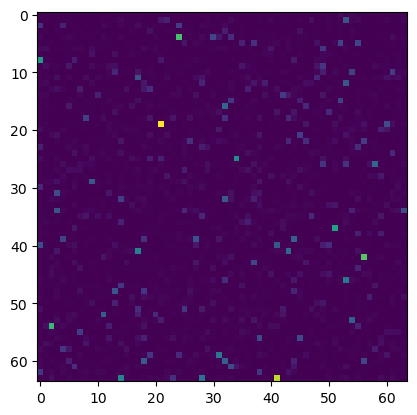

In [6]:
import numpy as np
import matplotlib.pyplot as plt

img = np.random.randint(0,255, size=(64,64))
mass = np.random.randint(0,255, size=(64,64))


#Avoid division by zero
mask = np.where(mass !=0)
div = np.zeros_like(img)
div[mask] = img[mask]/mass[mask]

# div = np.where(mass !=0, img/mass, img)
plt.imshow(div)

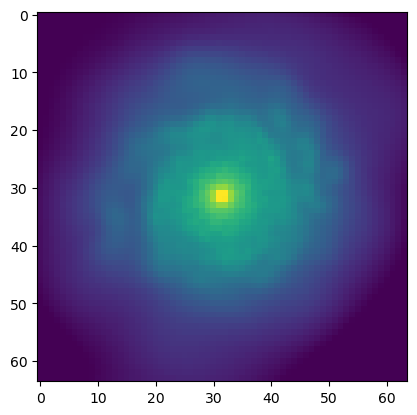

In [13]:
file = h5py.File("galaxy_data.hdf5", "r")

from matplotlib import pyplot as plt

plt.imshow(file["Galaxies/Particles/stars/Images/Masses"][1])










file.close()

In [1]:
from generate import generate_data

In [4]:
basePath = f"/export/data/ucakir/TNG100/TNG100-1/output/"




fields = {"Masses":{"mass_weighted": False,
                    "normed": False,
                    "plusone": True,
                    "log": True,
                        }, 
          
          "GFM_Metallicity":
              {"mass_weighted": False,
                    "normed": True,
                    "plusone": True,
                    "takelog": True,
            }, 
          "GFM_StellarFormationTime":
              {"mass_weighted": True,
                    "normed": True,
                    "plusone": True,
                    "takelog": True,
                        }} # Fields to calculated images for and if they are mass weighted or not







generate_data(simulation = "IllustrisTNG", halo_ids=[15,20], fields=fields, 
              plot_factor=10, image_res=(64,64), path="./", particle_types=["stars"], galaxy_parameters=["mass","halo_id"],
              **{"base_path":basePath,"halo_id":0,"particle_type": "stars", "snapshot":99})

2it [00:19,  9.64s/it]

Images calculated and saved to HDF5 file:  ./galaxy_data.hdf5


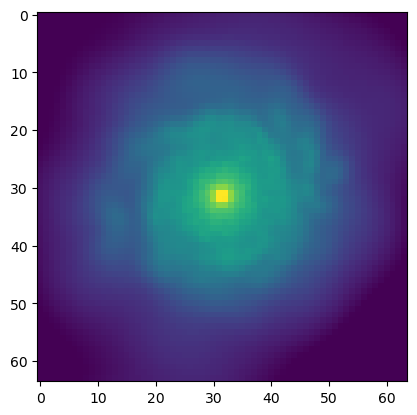

In [1]:
import h5py
import matplotlib.pyplot as plt
with h5py.File("galaxy_data.hdf5", "r") as f:
    plt.imshow(f["Galaxies/Particles/stars/Images/Masses"][1])
    plt.imshow(f["Galaxies/Particles/stars/Images/GFM_Metallicity"][1])

In [6]:
test = np.load("/export/home/ucakir/galaxy-morphology/experiments/corrupt_haloids.npy")

In [9]:
ids = np.load("/export/home/ucakir/galaxy-morphology/experiments/data/deeplearn_ids.npy")

In [14]:
# Check if the halo ids are in the corrupt halo ids
check = np.isin(ids, test)

# Get the indices of the corrupt halo ids
corr = ids[check]
print(corr)

#delete the corrupt halo ids and save the new array
new_ids = np.delete(ids, np.where(check))

np.save("deep_ids_wihtout_corrupt.npy", new_ids)

[31368 31369 31370 31371 31372 31373 31374 31375 31376 31377 31378 31379
 31380 31381 31382 31383 31384 31385 31386 31387 31388 31389 31390 31391
 31392 31393 31394 31396 31397 31398 31399 31400 31401 31402 31403 31404
 31405 31406 31407 31408 31409 31410 31412 31414 31415 31417 31418 31420
 31421 31422 31423]


In [8]:
test

array([31368, 31369, 31370, 31371, 31372, 31373, 31374, 31375, 31376,
       31377, 31378, 31379, 31380, 31381, 31382, 31383, 31384, 31385,
       31386, 31387, 31388, 31389, 31390, 31391, 31392, 31393, 31394,
       31396, 31397, 31398, 31399, 31400, 31401, 31402, 31403, 31404,
       31405, 31406, 31407, 31408, 31409, 31410, 31412, 31414, 31415,
       31417, 31418, 31420, 31421, 31422, 31423])

In [13]:
corr.shape, new_ids.shape, ids.shape, test.shape

((51,), (12484,), (12535,), (51,))

In [5]:
import numpy as np
with h5py.File("galaxy_data.hdf5", "r") as f:
    n, x, y = f["Galaxies/Particles/stars/Images/Masses"].shape
    reshaped = np.empty((n, x*y), dtype = f["Galaxies/Particles/stars/Images/Masses"].dtype)
    hyperslab = (slice(None), slice(None), slice(None))
    # output to a 2D array
    output_hyperslab=(slice(None), slice(None))
    f["Galaxies/Particles/stars/Images/Masses"].resize((n, x*y))

TypeError: New shape length (2) must match dataset rank (3)

In [8]:
fields={"Masses":False, "GFM_Metallicity":False, "GFM_StellarFormationTime":True}
fields["Masses"] 

False

In [5]:
test = {"1":0}
# Check if dictionary is empty
if not test:
    print("Empty")